In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.src.datasets import cifar10
from keras.api.models import Sequential
from keras.api.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Input
from keras.api.optimizers import Adam
from keras.api.losses import SparseCategoricalCrossentropy
from sklearn.metrics import f1_score
from keras.api.utils import to_categorical
from keras.api.models import load_model

(x_full_train, y_full_train), (x_test, y_test) = cifar10.load_data()
x_full_train = x_full_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
split_index = int(0.8 * len(x_full_train))
x_train, x_val = x_full_train[:split_index], x_full_train[split_index:]
y_train, y_val = y_full_train[:split_index], y_full_train[split_index:]


--- Eksperimen: CNN_Model ---
Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.3415 - loss: 1.8147 - val_accuracy: 0.6197 - val_loss: 1.0647
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.6454 - loss: 1.0036 - val_accuracy: 0.6958 - val_loss: 0.8822
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.7367 - loss: 0.7505 - val_accuracy: 0.7158 - val_loss: 0.8164
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.8006 - loss: 0.5656 - val_accuracy: 0.7487 - val_loss: 0.7509
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.8530 - loss: 0.4174 - val_accuracy: 0.7396 - val_loss: 0.7885
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9011 - loss: 0.2858 - val_accuracy: 0.7524 - val_loss: 0.8849
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.9310 - loss: 0.1996 - val_accuracy: 0.7565 - val_loss: 0.9402
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - acc

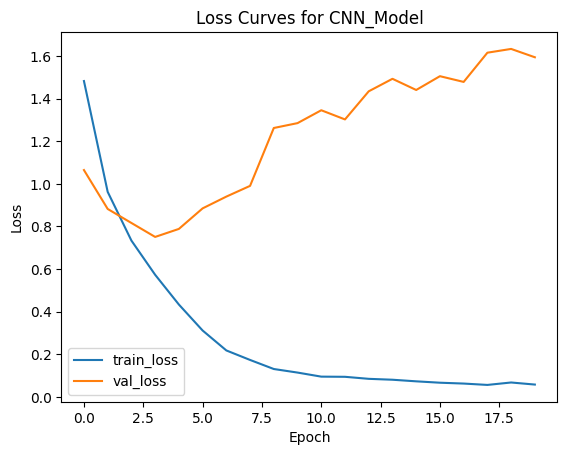

In [4]:
os.makedirs('models', exist_ok=True)

def build_cnn_scratch(num_conv_layers, filters_per_layer, kernel_sizes, pooling_type='max'):
    model = Sequential()
    model.add(Input(shape=x_train.shape[1:]))
    for i in range(num_conv_layers):
        model.add(Conv2D(filters=filters_per_layer[i], kernel_size=kernel_sizes[i],
                         activation='relu', padding='same'))
        if pooling_type == 'max':
            model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        else:
            model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dense(250, activation='relu'))
    model.add(Dense(20, activation='softmax'))
    model.compile(
        optimizer=Adam(),
        loss=SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )
    return model

def run_cnn_scratch(param: dict, epochs=20, batch_size=64):
    results = {}
    name = param['name']
    print(f"\n--- Eksperimen: {name} ---")
    model = build_cnn_scratch(
        param['num_conv_layers'],
        param['filters_per_layer'],
        param['kernel_sizes'],
        param['pooling_type']
    )
    history = model.fit(
        x_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_val, y_val),
        verbose=1
    )

    model_path = f"models/{name}.keras"
    model.save(model_path)
    print(f"Model disimpan di: {model_path}")

    y_pred = np.argmax(model.predict(x_test), axis=1)
    y_true = y_test.flatten()
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"Macro F1-score untuk {name}: {f1:.4f}")
    results[name] = {'history':history.history, 'f1_score':f1}

    plt.figure()
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(f"Loss Curves for {name}")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    return results

param = {'name':'CNN_Model', 'num_conv_layers':3, 'filters_per_layer':[128,256,512], 'kernel_sizes':[3,3,3], 'pooling_type':'max'}
saved_model = run_cnn_scratch(param, epochs=20, batch_size=64)

In [2]:
y_train_scr = to_categorical(y_train, 10)
y_val_scr = to_categorical(y_val, 10)
y_test_scr = to_categorical(y_test, 10)
y_test_labels = np.argmax(y_test_scr, axis=1)

class Conv2D_scr:
    def __init__(self, W, b, stride=1, padding='same'):
        self.W = W
        self.b = b
        self.stride = stride
        self.padding = padding

    def forward(self, x):
        fh, fw, _, out_ch = self.W.shape
        batch, h, w, _ = x.shape
        if self.padding == 'same':
            pad_h = (fh - 1) // 2
            pad_w = (fw - 1) // 2
            x = np.pad(x, ((0,0),(pad_h,pad_h),(pad_w,pad_w),(0,0)), mode='constant')
        out_h = (h + 2*pad_h - fh) // self.stride + 1
        out_w = (w + 2*pad_w - fw) // self.stride + 1
        out = np.zeros((batch, out_h, out_w, out_ch), dtype=np.float32)
        for i in range(out_h):
            for j in range(out_w):
                hs, he = i * self.stride, i * self.stride + fh
                ws, we = j * self.stride, j * self.stride + fw
                patch = x[:, hs:he, ws:we, :]
                for k in range(out_ch):
                    out[:, i, j, k] = np.sum(patch * self.W[..., k], axis=(1,2,3)) + self.b[k]
        return out

class ReLU_scr:
    def forward(self, x):
      return np.maximum(0, x)

class MaxPool2D_scr:
    def __init__(self, pool_size=(2,2), stride=2):
        self.ph, self.pw = pool_size
        self.stride = stride

    def forward(self, x):
        batch, h, w, ch = x.shape
        out_h = (h - self.ph) // self.stride + 1
        out_w = (w - self.pw) // self.stride + 1
        out = np.zeros((batch, out_h, out_w, ch), dtype=np.float32)
        for i in range(out_h):
            for j in range(out_w):
                hs, he = i * self.stride, i * self.stride+self.ph
                ws, we = j * self.stride, j * self.stride+self.pw
                patch = x[:, hs:he, ws:we, :]
                out[:, i, j, :] = np.max(patch, axis=(1,2))
        return out

class AvgPool2D_scr:
    def __init__(self, pool_size=(2,2), stride=2):
        self.ph, self.pw = pool_size
        self.stride = stride

    def forward(self, x):
        batch, h, w, ch = x.shape
        out_h = (h - self.ph) // self.stride + 1
        out_w = (w - self.pw) // self.stride + 1
        out = np.zeros((batch, out_h, out_w, ch), dtype=np.float32)
        for i in range(out_h):
            for j in range(out_w):
                hs, he = i * self.stride, i * self.stride + self.ph
                ws, we = j * self.stride, j * self.stride + self.pw
                patch = x[:, hs:he, ws:we, :]
                out[:, i, j, :] = np.mean(patch, axis=(1,2))
        return out

class Flatten_scr:
    def forward(self, x):
      return x.reshape(x.shape[0], -1)

class Dense_scr:
    def __init__(self, W, b):
        self.W, self.b = W, b

    def forward(self, x):
      return x.dot(self.W) + self.b

class Softmax_scr:
    def forward(self, x):
        e = np.exp(x - np.max(x, axis=1, keepdims=True))
        return e / np.sum(e, axis=1, keepdims=True)

model_path = ('models/CNN_Model.keras')
keras_model = load_model(model_path)

layers = []
for layer in keras_model.layers:
    if isinstance(layer, Conv2D):
        W, b = layer.get_weights()
        layers.append(Conv2D_scr(W, b, stride=layer.strides[0], padding=layer.padding))
        layers.append(ReLU_scr())
    elif isinstance(layer, MaxPooling2D):
        layers.append(MaxPool2D_scr(pool_size=layer.pool_size, stride=layer.strides[0]))
    elif isinstance(layer, Flatten):
        layers.append(Flatten_scr())
    elif isinstance(layer, Dense):
        W, b = layer.get_weights()
        layers.append(Dense_scr(W, b))
        act = layer.activation.__name__
        if act == 'softmax':
          layers.append(Softmax_scr())
        elif act == 'relu':
          layers.append(ReLU_scr())

def scratch_predict(x):
    out = x.copy()
    for l in layers:
        out = l.forward(out)
    return out

scratch_out = scratch_predict(x_test)
scratch_pred = np.argmax(scratch_out, axis=1)

keras_out = keras_model.predict(x_test)
keras_pred = np.argmax(keras_out, axis=1)

print('Scratch Macro F1:', f1_score(y_test_labels, scratch_pred, average='macro'))
print('Keras Macro F1:', f1_score(y_test_labels, keras_pred, average='macro'))

313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step
Scratch Macro F1: 0.7237685392945128
Keras Macro F1: 0.7237685392945128
